In [1]:
import numpy as np
from typing import Union, Optional, Sequence, Any, Mapping, List, Tuple
import scanpy as sc
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy import ndimage
from sklearn.cluster import DBSCAN

In [2]:
def pickGene(adata, topN):
    try:
        L = adata.X.toarray()
    except:
        L = adata.X
    return L[:,topN]

In [3]:
def getAdataShape(adata):
    n, m = (adata.obs["array_row"].max() - adata.obs["array_row"].min(), 
            adata.obs["array_col"].max() - adata.obs["array_col"].min())
    return n, m

def _get_data_points(adata, scale_factor = 0.04155585) -> Tuple[List[np.ndarray], List[Tuple[int, int]]]:
    """
    Returns the data points corresponding to the selected basis, projection and/or components.
    Because multiple components are given (eg components=['1,2', '2,3'] the
    returned data are lists, containing each of the components. When only one component is plotted
    the list length is 1.
    Returns
    -------
    data_points
        Each entry is a numpy array containing the data points
    components
        The cleaned list of components. Eg. [(0,1)] or [(0,1), (1,2)]
        for components = [1,2] and components=['1,2', '2,3'] respectively
    """
    basis_key = "spatial"
    n_dims, offset = 2, 0
    
    data_points = np.array(adata.obsm[basis_key])[:, offset : offset + n_dims]
    
    data_points = np.multiply(data_points, scale_factor)

    return data_points

In [4]:
def getData(adata):
    data_points = _get_data_points(adata)
    n, m = getAdataShape(adata)
    X_r = np.linspace(data_points[:,0].min(), data_points[:,0].max(), m + 1)
    Y_r = np.linspace(data_points[:,1].min(), data_points[:,1].max(), n + 1)
    return data_points, X_r, Y_r


In [5]:
def getPointsIndicies(X_r, Y_r):
    points, indicies = list(), list()
    for i,x in enumerate(X_r):
        for j,y in enumerate(Y_r):
            points.append((x,y))
            indicies.append((i,j))
    return np.array(points), np.array(indicies)

def getImgs(X_r, Y_r, data_points, cvals):
    nan_valueArr = np.empty((len(X_r), len(Y_r)))
    nan_valueArr[:] = np.nan
    zero_valueArr = np.zeros((len(X_r), len(Y_r)))
    for pt, v in zip(data_points, cvals):
        flidx = ((points - pt) ** 2).sum(1).argmin()
        ixs = indicies[flidx]
        nan_valueArr[ixs[0], ixs[1]] = v
        zero_valueArr[ixs[0], ixs[1]] = v
    
    return np.rot90(nan_valueArr), np.rot90(zero_valueArr)

def imgPositions(X_r, Y_r):
    xv, yv = np.meshgrid(np.arange(len(X_r)), 
                         np.arange(len(Y_r)), 
                         sparse=False, 
                         indexing='xy')
    positions = np.vstack([xv.flatten(), yv.flatten()]).T
    return positions

def getImg(main_img, X_r, Y_r):
    positions = imgPositions(X_r, Y_r)
    vals = main_img.flatten()
    vals_no_nan, positions_no_nan, positions_nan = (vals[~np.isnan(vals)], 
                                                positions[~np.isnan(vals)], 
                                                positions[np.isnan(vals)])
    new_vals = griddata(positions_no_nan,
                    vals_no_nan,
                    (positions_nan[:,0],
                     positions_nan[:,1]),
                    method = "linear")
    new_vals = new_vals.flatten()
    vals[np.isnan(vals)] = new_vals
    X = vals.reshape(main_img.shape)
    return X

def getTopNExpressedGenes(adata, topN):
    ixs = np.argsort(adata.X.toarray().sum(0))[::-1]
    top10 = ixs[:topN]
    maxMask = np.array([True if i in top10 else False for i in range(adata.X.shape[1])])
    return adata[:,maxMask]

In [6]:
adata = sc.read_visium("/data/ekvall/MOB/V19D02-086_A1")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [7]:
adata.var_names_make_unique()

Remove mitochondrial genes

In [8]:
adata.var['mt'] =  adata.var_names.str.startswith('mt-')
adata = adata[:, ~adata.var['mt']]

Remove ribosomal genes

In [9]:
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
adata = adata[:, ~adata.var['ribo']]

Trying to set attribute `.var` of view, copying.


Log transform

In [10]:
sc.pp.log1p(adata)

/home/markus.ekvall/anaconda3/envs/py3.9_sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Keep highly variable genes

In [11]:
adata = getTopNExpressedGenes(adata, 10)

In [12]:
sc.pp.scale(adata, max_value=10)


/home/markus.ekvall/anaconda3/envs/py3.9_sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [13]:
data_points, X_r, Y_r = getData(adata)
cvals = pickGene(adata, 0)

In [17]:
def removeOutliers(data_points, cvals, scale=0.3):
    dists = list()
    ixs = np.arange(len(data_points))
    for _ in range(10000):
        a,b = np.random.choice(ixs, 2)
        dists.append(np.linalg.norm(data_points[a] - data_points[b]))
    model = DBSCAN(eps = scale * np.mean(dists), min_samples = 10)
    model.fit(data_points, cvals)
    mask = model.labels_ == 0
    data_points = data_points[mask]
    cvals = cvals[mask]
    return data_points, cvals

In [18]:
data_points, cvals = removeOutliers(data_points, cvals)

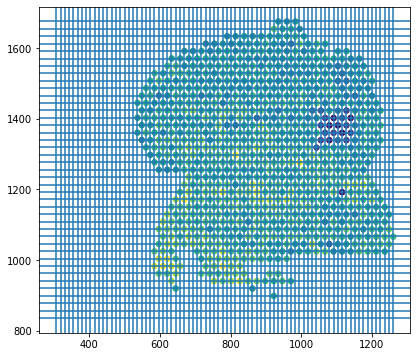

In [19]:
marker_size  = 30
fig,ax = plt.subplots(1,1,figsize = (15,6))
ax.scatter(data_points[:,0] ,data_points[:,1], s=marker_size, c=cvals)

for r in X_r:
    ax.axvline(x=r)
for r in Y_r:
    ax.axhline(y=r)
    
ax.set_aspect("equal")

In [20]:
points, indicies = getPointsIndicies(X_r, Y_r)

In [21]:
main_img, zero_img = getImgs(X_r, Y_r, data_points, cvals) 

In [22]:
img_silhoute =  ndimage.morphology.binary_fill_holes(zero_img).astype(int)
main_img[img_silhoute==0]= min(cvals)

In [23]:
X = getImg(main_img, X_r, Y_r)

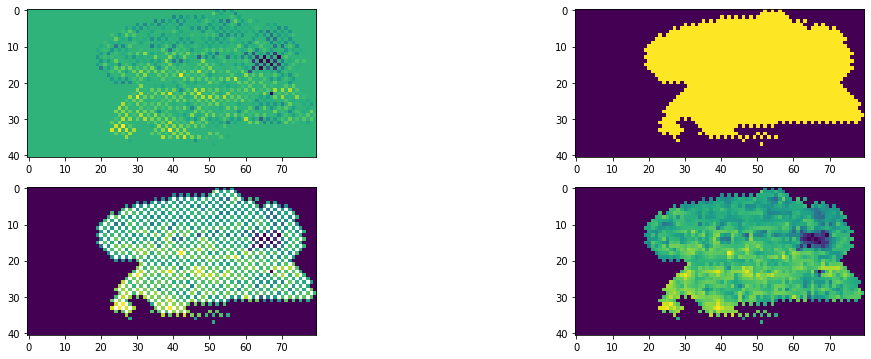

In [24]:
fig,ax = plt.subplots(2,2,figsize = (18,6))
                      
ax[0,0].imshow(zero_img)
ax[0, 1].imshow(img_silhoute)
ax[1,0].imshow(main_img)
ax[1,1].imshow(X)

In [28]:
def getExpressionImg(adata, topN):
    data_points, X_r, Y_r = getData(adata)
    cvals = pickGene(adata, topN)
    data_points, cvals = removeOutliers(data_points, cvals)
    points, indicies = getPointsIndicies(X_r, Y_r)
    main_img, zero_img = getImgs(X_r, Y_r, data_points, cvals) 
    img_silhoute =  ndimage.morphology.binary_fill_holes(zero_img).astype(int)
    main_img[img_silhoute==0]=min(cvals)
    X = getImg(main_img, X_r, Y_r)
    return X

In [29]:
imgs = list()
for i in range(10):
    imgs.append(getExpressionImg(adata, i))

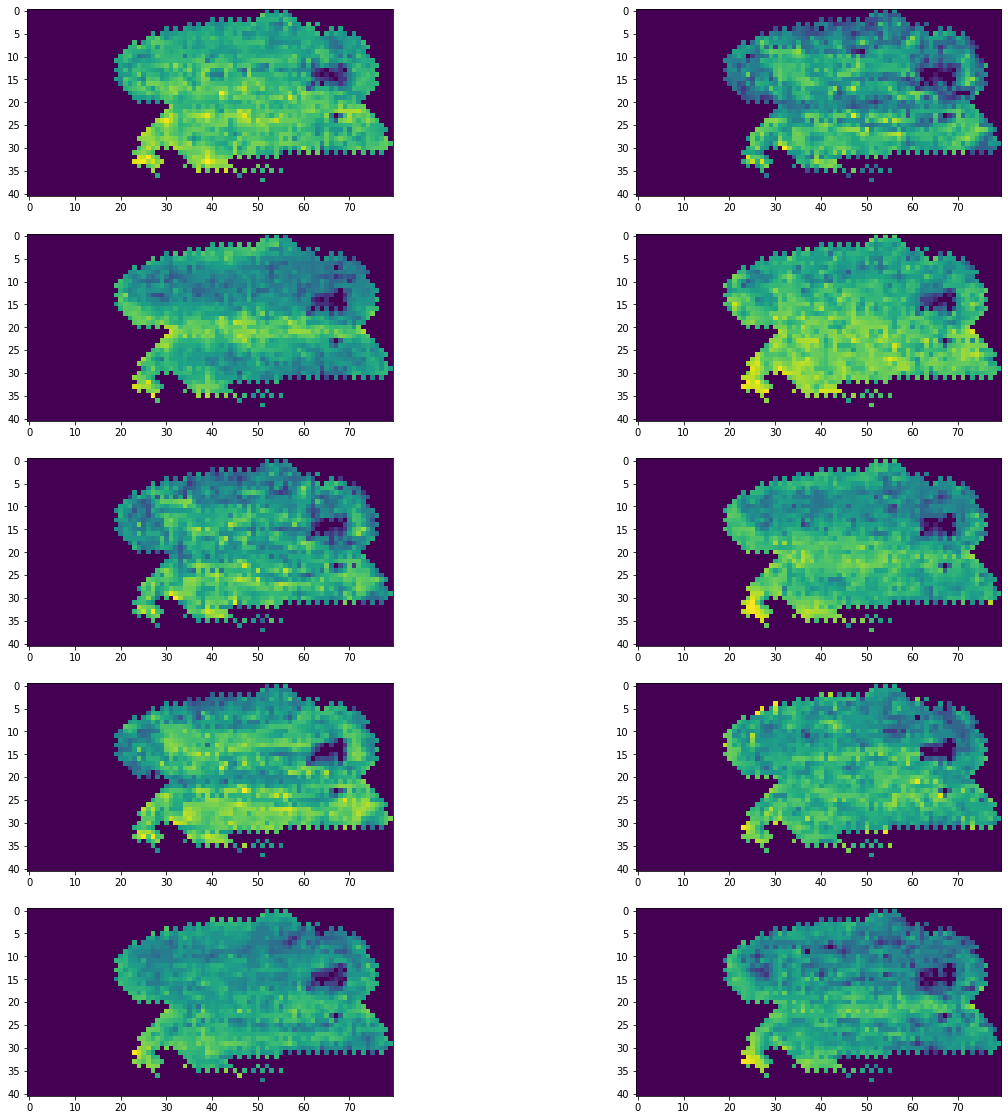

In [30]:
fig,ax = plt.subplots(5,2,figsize = (20,20))

for i,img in enumerate(imgs):
    ax[int(i/2),i % 2].imshow(img)
    ax[int(i/2),i % 2].set_aspect("equal")